<br>

# Extract tree top coordinates

This notebook takes an aerial spectral orthophoto (channels: red, green, blue and infrared) from the black forest in .tiff format as input, extracts the coordinates of individual leaf trees from it and shifts the imprecise GPS coordinates of labeled leaf trees from the field to them.

1. In a first step, tree top coordinates are defined as local maxima on a map of vegetation heights, the so called canopy height model which is loaded from the file called "Lidar2021_vegheight_int16_04m_cm_weg30m.tif".

2. In a second step, only coordinates of leaf trees are kept while that of needle-like trees are discarded. To distinguish coordinates that correspond to either leaf or needle-like trees, we calculate the normalized difference vegetation index (NDVI) for a small rectengular portion around each tree top coordinate. The NDVI ranges from -1 to 1 reflecting no vegetation and high vegetation each. While needle-like trees should exhibit a similar vegetation index in winter and summer, the vegetation index should be very different between seasons for leaf trees. Thus, we compare the NDVI between the summer and winter and discard those tree top coordinates that show no sufficient difference.

3. In a third step, we match the previously identified tree top coordinates of leaf trees with the labeled GPS tree coordinates that we have received from the field. These GPS tree coordinates are loaded from the .csv called "Laubbäume_utm32.csv" and may be inaccurate by several meters due to inaccuracies in the GPS signal – especially in forests. Thus, our goal is to shift the labeled tree coordinates as precisely as possible to a tree top and thereby center the box image of each tree (that we will extract in our next notebook) on the highest point of its crown. Eventually, the labeled and shifted leaf tree coordinates are saved in the very same .csv file called "Laubbäume_utm32.csv".

<br>

**Data you need for running this notebook**

1. Aerial spectral orthophotos from the area you want to inspect – the TIFF file must be stored in the data folder

2. Spectral maps from summer and winter of the desired area – both TIFF files must be stored in a NDVI subfolder in the data folder

<br>

**Content overview**

* [Step 0: Setup](#step-0-setup)

* [Step 1: Define tree tops as local maxima in the canopy height model](#step-1-define-tree-tops-as-local-maxima-in-the-canopy-height-model)

* [Step 2: Using the NDVI season difference to detect leaf trees](#step-2-using-the-ndvi-season-difference-to-detect-leaf-trees)

* [Step 3: Shifting geo coordinates of labeled trees](#step-3-shifting-geo-coordinates-of-labeled-trees)

---

---

### Step 0: Setup

In [1]:
# Toolboxes for data handling
import pandas as pd
import numpy as np

# Toolboxes for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Toolboxes for raster handling
import rasterio

# Toolboxes for image handling
from scipy import ndimage
from skimage.feature import peak_local_max

# Toolboxes for warning handling
import warnings

In [2]:
# Ignore warnings for this notebook
warnings.filterwarnings("ignore")

In [3]:
# Define the path to the map that contains the vegetation height
# (canopy height model)
vegheight_path = './data/LiDAR/Lidar2021_vegheight_int16_04m_cm_weg30m.tif'

# Load the canopy height model
vegheight = plt.imread(vegheight_path)

----

---

### Step 1: Define tree tops as local maxima in the canopy height model

In [4]:
# Define the standard deviation for the Gaussian kernel
sd_kernel = 1.9

# Apply smoothing to the canopy height model to remove spurious high
# vegetation points in the map and hence noise
vegheight_smooth = ndimage.gaussian_filter(vegheight, sigma=sd_kernel)

# Define a threshold for the minimum size of trees in centimeters
height_threshold = 300

# Define a minimal allowed distance between neighboring peaks
minimal_distance = 1

# Extract local maxima in the canopy height model
coords = peak_local_max(vegheight_smooth, min_distance=minimal_distance,
                             threshold_abs=height_threshold)

Compare different Gaussian Kernels (if unsure which one to use)

In [5]:
# # Define the range of sigma values
# sigma_values = np.arange(0, 2.5, 0.5)

# # Define height_threshold and minimal_distance
# height_threshold_comparison = 300 
# minimal_distance_comparison = 1

# # List to store the number of local maxima for each sigma value
# coords_n = []

# # Loop through all sigma values
# for sigma in sigma_values:
    
#     # Apply Gaussian filter
#     vegheight_smooth = ndimage.gaussian_filter(vegheight, sigma=sigma)
    
#     # Find local maxima
#     coords_tmp = peak_local_max(vegheight_smooth, 
#                                 min_distance=minimal_distance_comparison, 
#                                 threshold_abs=height_threshold_comparison)
    
#     # Calculate the number of local maxima
#     coords_n.append(len(coords_tmp))

# # Create a DataFrame from the results
# df_coords_n = pd.DataFrame({'Sigma': sigma_values, 
#                                     'Number of Local Maxima': coords_n})

# # Show the number of maxima that have been extracted from the canopy height model
# # depending on which sigma has been chosen in the Gaussian smoothing
# print(df_coords_n)

Translate pixel coordinates to geo coordinates to plot the coordinates e.g. in QGIS and other software that handles raster data

In [6]:
# Get information on how to transform pixel coordinates to geo coordinates by
# loading the canopy height model in its original raster format
with rasterio.open(vegheight_path) as data:

    # Extract the transformation information
    transform = data.transform
    
# List to store the coordinates of local maxima (treetops)
tt_coords = []

# Loop through the pixel coordinates of each treetop
for i in range(coords.shape[0]):
    
    # Determine the geo coordinates of this local maximum
    lon, lat = rasterio.transform.xy(transform, coords[i,0], coords[i,1])
    tt_coords.append((lon, lat))
    
# Turn list of tree tops into a dataframe
ttc_df = pd.DataFrame(tt_coords)

# Rename the coordinate columns
ttc_df.columns = ['x_geo', 'y_geo']

---

---

### Step 2: Using the NDVI season difference to detect leaf trees

Function to transform geo coordinates of treetops to pixel coordinates in the aerial spectral orthophoto

In [7]:
# Define a function to translate geo-coordinates to pixel coordinates
def pixel_coordinate_translation(ttc_df, transform):

    # Report that geo coordinates will be translated to pixel coordinates
    print('Started the translation of tree coordinates from geo to pixel.',
          end='\n')
    
    # Create two new columns in the tree top coordinate data frame that will
    # contain the pixel coordinate information
    ttc_df['x_pix'] = np.full(ttc_df.shape[0], fill_value=np.nan)
    ttc_df['y_pix'] = np.full(ttc_df.shape[0], fill_value=np.nan)

    # Loop through the coordinates of all treetops
    for i, row in ttc_df.iterrows():

        # Extract the coordinate information of a single treetop
        longitude = row['x_geo']
        latitude = row['y_geo']

        # Translate the coordinate to a pixel coordinate
        y_pix, x_pix = ~transform * (longitude, latitude)

        # Add the pixel coordinates to the data frame
        ttc_df.loc[i,'x_pix'] = int(x_pix)
        ttc_df.loc[i,'y_pix'] = int(y_pix)

        # Report progress each time after 100 treetop coordinates have been
        # translated
        if (((i+1)%100) == 0) and (((i+1)%1000) > 0):
            print('.', end='')
        elif (((i+1)%1000) == 0):
            print('; ' + str(i+1) + ' tree coordinates have been ' + 
                'translated (' + str((100*i)//ttc_df.shape[0]) + '%)', 
                end='\n')
        elif ((i+1) == ttc_df.shape[0]):
            print('; ' + str(i+1) + ' tree coordinates have been ' + 
                'translated (' + str(100) + '%)', end='\n')

    # Report that geo coordinates have been translated to pixel coordinates
    print('Finished the translation of tree coordinates from geo to pixel.',
          end='\n\n')

    # Return the pixel coordinates that have been added to the dataframe
    return ttc_df

Function to extract image boxes around each treetop pixel coordinate:

In [8]:
# Define a function to extract image boxes around tree top pixel coordinates
def extract_treetop_imageboxes(ttc_df, path_summer, path_winter):
    
    # Report that image boxes will be extracted from the spectral data
    print('Started the extraction of image boxes.', end='\n')

    # Define the size of the box as an odd number to center it on the exact
    # tree top pixel coordinate (here: 3.5 meters)
    box_size = 35

    # Define an empty array that will later contain all box images
    tt_box_array = np.full((2, ttc_df.shape[0], box_size, box_size, 4), 
                           fill_value=np.nan)
    

    # Keep the spectral data of the summer ready to be loaded but do
    # not load the whole map
    with rasterio.open(path_summer) as data_summer, \
         rasterio.open(path_winter) as data_winter:
    
        # Define the pixel coordinate limits of the image
        x_max_img = int(data_summer.shape[0])
        y_max_img = int(data_summer.shape[1])
    
        # Iterate through all rows of the treetop pixel coordinates
        for i, row in ttc_df.iterrows():
            
            # Get the pixel coordinate of the treetop
            x_ttpc = int(row['x_pix'])
            y_ttpc = int(row['y_pix'])

            # Define the pixel coordinates of the box
            y_min_box = y_ttpc - box_size//2
            y_max_box = y_ttpc + box_size//2 + 1
            x_min_box = x_ttpc - box_size//2
            x_max_box = x_ttpc + box_size//2 + 1

            # Check whether the box stays inside of the image limits
            if (y_min_box >= 0) and (y_max_box <= y_max_img) and \
            (x_min_box >= 0) and (x_max_box <= x_max_img):
            
                # Define a box around the treetop coordinate that should be
                # extracted
                box_window = rasterio.windows.Window(y_min_box, x_min_box,
                                                    box_size, box_size)

                # Extract the box image and transpose it as rasters are in the
                # shape: channels, width, height while we need width, height,
                # channels
                tt_box_array[0,i,:,:,:] = \
                    np.transpose(data_summer.read(window=box_window), (1,2,0))
                tt_box_array[1,i,:,:,:] = \
                    np.transpose(data_winter.read(window=box_window), (1,2,0))                    
                
            # Report progress each time after 1000 boxes have been extracted
            if (((i+1)%100) == 0) and (((i+1)%1000) > 0):
                print('.', end='')
            elif (((i+1)%1000) == 0):
                print('; ' + str(i+1) + ' trees have been processed (' + 
                    str((100*i)//ttc_df.shape[0]) + '%)', end='\n')
            elif ((i+1) == ttc_df.shape[0]):
                print('; ' + str(i+1) + ' trees have been processed (' + 
                    str(100) + '%)', end='\n')
            
    # Report that image boxes have been extracted from the spectral data
    print('Finished the extraction of image boxes.', end='\n\n')

    # Return the array containing all image boxes placed around tree tops
    return tt_box_array

Function to calculate the normalized difference vegetation index (NDVI):

In [9]:
# Define a function to calculate the ndvi
def calculate_ndvi(ttc_df, tt_box_array):
    
    # Report that ndvi scores will be calculated
    print('Started the calculation of ndvi scores.', end='\n')    

    # Calculate the ndvi for the summer
    ndvi_summer = ((tt_box_array[0,:,:,:,3] - 
                    tt_box_array[0,:,:,:,0]) / 
                   (tt_box_array[0,:,:,:,3] + 
                    tt_box_array[0,:,:,:,0]))

    # Calculate the summer average
    ndvi_summer_avg = np.mean(ndvi_summer, axis=(1,2))

    # Calculate the ndvi for the winter
    ndvi_winter = ((tt_box_array[1,:,:,:,3] -
                    tt_box_array[1,:,:,:,0]) / 
                   (tt_box_array[1,:,:,:,3] + 
                    tt_box_array[1,:,:,:,0]))

    # Calculate the winter average
    ndvi_winter_avg = np.mean(ndvi_winter, axis=(1,2))

    # Calculate the difference between summer and winter
    ndvi_avg_diff = ndvi_summer_avg - ndvi_winter_avg

    # Append information to the data frame
    ttc_df['ndvi_summer_avg'] = ndvi_summer_avg
    ttc_df['ndvi_winter_avg'] = ndvi_winter_avg
    ttc_df['ndvi_diff_avg']   = ndvi_avg_diff

    # Report that ndvi scores have been calculated
    print('Finished the calculation of ndvi scores.', end='\n\n')  

    # Return the ttc_df as well as arrays of ndvi
    return ttc_df, ndvi_summer, ndvi_winter

Function to find a decision boundary to distinguish needle-like from leaf trees:

In [10]:
# Define a function that performs a distinction between needle-like and
# leaf trees
def check_for_leaf_trees(ttc_df):
            
      # Report that tree tops will be assigned to either needle-like or
      # leaf trees
      print('Started the distinction between needle-like and leaf trees.',
            end='\n')

      # Define a threshold for classifying a needle-like tree and hence
      # drop its treetop coordinate from erroneously assigning it to be
      # a leaf tree
      thresh = .45

      # Add the information whether the full image contains information
      # to the data frame
      ttc_df['img_complete'] = (np.isnan(ttc_df['ndvi_diff_avg']) == False)

      # Add to the data frame whether all pixels in the box image contain
      # information
      print(str(round(100*np.mean(ttc_df['img_complete']))) + 
            '% of all tree tops have been marked to be part of a ' + 
            'complete image.')

      # Add to the data frame whether the box image reflects a leaf tree
      # or not
      ttc_df['img_leaf'] = ttc_df['ndvi_diff_avg'] > thresh

      # Report on how many treetops have been classified as leaf trees
      print(str(round(100*np.mean(ttc_df['img_leaf']))) +
            '% of all tree tops have been marked as being leaf trees.')

      # Report that tree tops have been assigned to either needle-like or
      # leaf trees
      print('Finished the distinction between needle-like and leaf trees.',
            end='\n\n')

      # Return the extended data frame
      return ttc_df

Execute all functions to decide whether a treetop corresponds to a needle-like or leaf tree. Only keep coordinates of the leaf trees.

In [11]:
# Announce that processing has started
print('\nProcessing has started!', end='\n\n')

# Define paths to the aerial spectral orthophotos
summer_path = './data/TDOP/TDOP_2022_weg30m.tif'
winter_path = './data/TDOP/TDOP_2021_weg30m.tif'

# Load information on how to transform geo coordinates
# to pixel coordinates in the aerial spectral orthophoto
with rasterio.open(summer_path) as data:
    
    # Extract info regarding the transformation of pixel to geo-
    # coordinates
    transform = data.transform

# Translate geo coordinates of treetops to pixel coordinates
# in the aerial spectral orthophoto
ttc_df = pixel_coordinate_translation(ttc_df, transform)

# Extract image boxes around treetop coordinates for each season
tt_box_array = \
    extract_treetop_imageboxes(ttc_df, summer_path, winter_path)

# Calculate the ndvi
ttc_df, ndvi_summer, ndvi_winter = calculate_ndvi(ttc_df, tt_box_array)

# Add the nvdi information to the data frame and classify treetops to
# either belong to needle-like or leaf trees
ttc_df = check_for_leaf_trees(ttc_df)

# Announce that processing has finished
print('Processing has finished!', end='\n')


Processing has started!

Started the translation of tree coordinates from geo to pixel.
.........

; 1000 tree coordinates have been translated (2%)
.........; 2000 tree coordinates have been translated (4%)
.........; 3000 tree coordinates have been translated (6%)
.........; 4000 tree coordinates have been translated (9%)
.........; 5000 tree coordinates have been translated (11%)
.........; 6000 tree coordinates have been translated (13%)
.........; 7000 tree coordinates have been translated (15%)
.........; 8000 tree coordinates have been translated (18%)
.........; 9000 tree coordinates have been translated (20%)
.........; 10000 tree coordinates have been translated (22%)
.........; 11000 tree coordinates have been translated (24%)
.........; 12000 tree coordinates have been translated (27%)
.........; 13000 tree coordinates have been translated (29%)
.........; 14000 tree coordinates have been translated (31%)
.........; 15000 tree coordinates have been translated (33%)
.........; 16000 tree coordinates have been translated (36%)
.........; 17000 tree coordinates have been tr

Plot the NDVI for summer, winter and their difference:

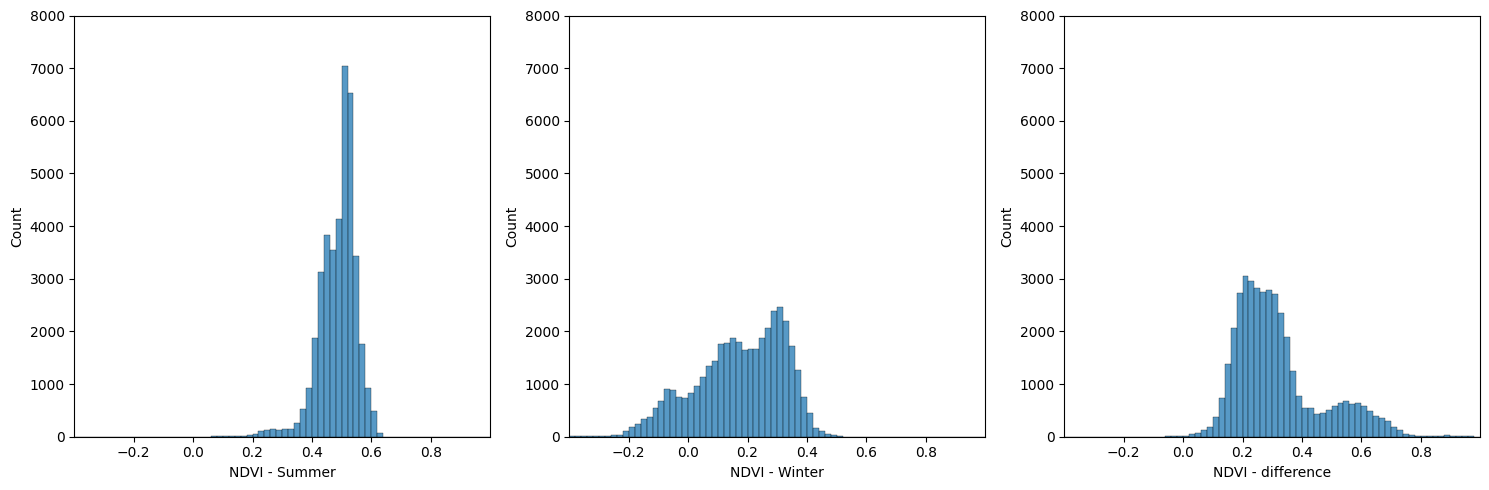

In [24]:
# Open the figure
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plot the ndvi for the summer
fig0 = sns.histplot(ttc_df['ndvi_summer_avg'], ax=ax[0], bins=100,
                    binrange=(-1,1))

# Change the axes layout
ax[0].set_xlim(-.4, 1)
ax[0].set_ylim(0, 8000)
fig0.set(xticks=np.arange(-.2,1.0,.2))
fig0.set(xlabel='NDVI - Summer');

# Plot the ndvi for the winter
fig1 = sns.histplot(ttc_df['ndvi_winter_avg'], ax=ax[1], bins=100,
                    binrange=(-1,1))

# Change the axes layout
ax[1].set_xlim(-.4, 1)
ax[1].set_ylim(0, 8000)
fig1.set(xticks=np.arange(-.2,1.0,.2))
fig1.set(xlabel='NDVI - Winter');

# Plot the ndvi for the summer winter difference
fig2 = sns.histplot(ttc_df['ndvi_diff_avg'], ax=ax[2], bins=100,
                    binrange=(-1,1))

# Change the axes layout
ax[2].set_xlim(-.4, 1)
ax[2].set_ylim(0, 8000)
fig2.set(xticks=np.arange(-.2,1.0,.2))
fig2.set(xlabel='NDVI - difference');

# Show the figure
plt.tight_layout()
plt.show()

Plot the NDVI only for the difference summer - winter:

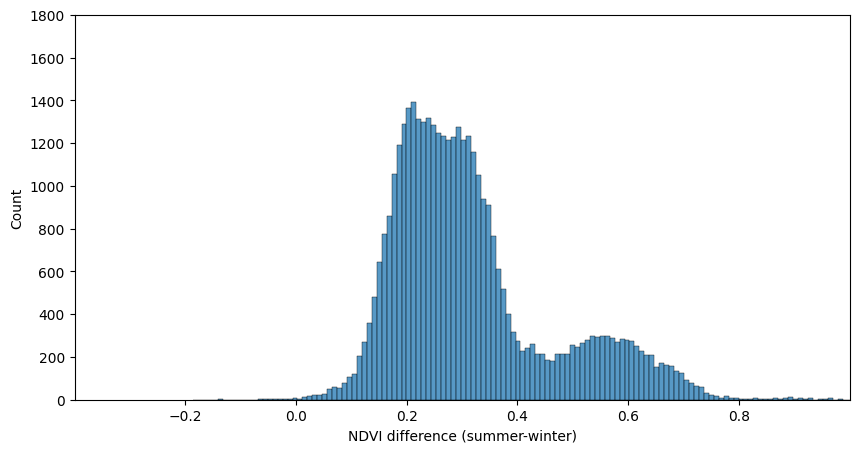

In [25]:
# Plot the ndvi for the summer-winter
fig, ax = plt.subplots(1, 1, figsize=(10,5))
fig = sns.histplot(ttc_df['ndvi_diff_avg'])
ax.set_xlim(-.4, 1.0)
ax.set_ylim(0, 1800)
fig.set(xlabel='NDVI difference (summer-winter)')
fig.set(xticks=np.arange(-.2, 1, .2));


Conclusion from the plot:

* Two extrema should be distinguishable by eye. In the original use case: A large extrema formed around .25 while a smaller one formed around .55.

* Differences closer to zero likely result from NDVI values being similar in summer and winter (needle-like trees) while larger values likely result from NDVI values being larger in summer and smaller in winter (leaf trees). Accordingly, we want to include only the latter into our analysis pipeline.

* Based on the plot, a lower and upper value for the NDVI of deciduous trees must now be defined. In the original use case, this was defined as .45 and higher. With this threshold we will erroneously exclude some leaf trees but will include not that many needle-like leaf trees in our further processing.


---

---

### Step 3: Shifting geo coordinates of labeled trees

The general aim of this step is to shift each tree coordinate to the tree top that is closest to it. As it occurs that multiple tree coordinates are shifted to the same treetop, these duplicate assignments need to be handled so that only the assignment with the shortest distance remains.

In [27]:
# Only keep treetops with complete box images and a deciduous tree content
ttc_df = ttc_df[(ttc_df['img_complete'] == True) & (ttc_df['img_leaf'] == True)]

# Add an identifier variable
ttc_df['id'] = np.arange(0, ttc_df.shape[0], 1)

# Reset the index as rows have been dropped
ttc_df.reset_index(drop=True, inplace=True)

Import the coordinates of the original but cleaned labeled trees:

In [38]:
# Load the tree coordinates, this a cleaned version, in which
# trees that show the exact same coordinates or are outside of
# investigated area have been dropped
tc_df = pd.read_csv('./data/Laubbäume_utm32_cleaned.csv')

# Only extract columns that will be relevant in the further processing
tc_df = tc_df[['X', 'Y', 'desc']]

# Rename columns
tc_df.columns = ['x_geo', 'y_geo', 'label']

# Check for tree coordinates that are duplicates of each other and throw
# them away
tc_df = tc_df[tc_df[['x_geo', 'y_geo']].duplicated(keep=False) == False].\
    reset_index(drop=True)

# Add a column that delineates lists of previous ids of treetops that it
# should have been shifted to but another tree was closer
tc_df['prev_shift_id'] = [[] for _ in range(len(tc_df))]

# Add a column that contains the id of the treetop that the tree coordinate
# is currently shifted to
tc_df['last_shift_id'] = [np.nan for _ in range(len(tc_df))]

# Add a column that contains the distance of the tree coordinate from the
# treetop that it is currently shifted to
tc_df['last_distance'] = [np.nan for _ in range(len(tc_df))]

Define functions for allocating tree coordinates to treetop coordinates:

In [39]:
# Define a function to check whether a list is empty
def check_list_empty(lst):
    return (np.sum(np.isnan(lst)) > 0)

# Define a function to check whether there are any duplicates in a list
def check_list_duplicates(lst):
    return (len(np.unique(lst)) < len(lst))

Perform the allocation of tree coordinates to treetop coordinates:

In [40]:
# Run the following code as long as the list of id allocations is either (1)
# empty (tree coordinate has not been assigned to a treetop) or (2) contains
# duplicates (multiple trees coordinates have been assigned to the same
# treetop)
while check_list_empty(tc_df['last_shift_id']) or \
      check_list_duplicates(tc_df['last_shift_id']):

    # Determine rows that have no treetop allocation
    tta_missing = np.where(np.isnan(tc_df['last_shift_id']))

    # Loop through all tree coordinates that currently have no treetop
    # allocation
    for i in tta_missing[0]:

        # Extract a single tree coordinate
        tc = (tc_df.loc[i,'x_geo'], tc_df.loc[i,'y_geo'])

        # Extract the matching history for this tree coordinate
        tc_hist = tc_df.loc[i,'prev_shift_id']

        # Drop all treetop coordinates that have already been matched with
        # this tree coordinate before
        ttc_dft = ttc_df.drop(tc_hist, axis=0).reset_index(drop=True)

        # Calculate the distance between this tree coordinate and all
        # (remaining) treetop coordinates
        dist_lst = np.sqrt(np.sum((ttc_dft[['x_geo', 'y_geo']] - tc) ** 2,
                                  axis=1))
        
        # Find the treetop index with the minimum distance
        ind_min = np.argmin(dist_lst)

        # Add this treetop id to the history of matched treetop ids
        tc_df.loc[i,'prev_shift_id'].append(ttc_dft.loc[ind_min,'id'])

        # Set the treetop that corresponds to this minimum distance as the
        # last shift id
        tc_df.loc[i,'last_shift_id'] = ttc_dft.loc[ind_min,'id']

        # Save the distance to allow for comparisons later on
        tc_df.loc[i,'last_distance'] = dist_lst[ind_min]

    # Check for duplicate assignments and summarize the respective treetop
    # ids in a list
    duplicates = tc_df['last_shift_id'].value_counts().reset_index()
    duplicates = \
        duplicates.loc[duplicates['count'] > 1,'last_shift_id'].tolist()

    # Loop through each duplicate value
    for di in duplicates:
        
        # Extract indexes for duplicate assignments
        duplicates_ind = tc_df['last_shift_id'] == di

        # Check for each duplicate treetop coordinate which tree coordinate
        # has the closest distance to it
        dist_min = tc_df.loc[duplicates_ind, 'last_distance'].min()

        # Extract indexes for tree coordinates that do not show that exact
        # distance from their assigned treetop
        distance_ind = (tc_df['last_distance'] != dist_min)

        # Combine indexes to find pairs of tree coordinates and treetops
        # that need be unassigned again as they do not show the shortest
        # distance between each other
        farther_ind = np.where(duplicates_ind & distance_ind)

        # Assign these tree coordinates once again an nan so that a new
        # treetop can be found for them
        tc_df.loc[farther_ind[0],'last_shift_id'] = np.nan
        tc_df.loc[farther_ind[0],'last_distance'] = np.nan

Assign each tree coordinate its new tree top coordinate:

In [41]:
# Predefine new columns that will contain the allocated treetop coordinates
tc_df['x_geo_new'] = [np.nan for _ in range(len(tc_df))]
tc_df['y_geo_new'] = [np.nan for _ in range(len(tc_df))]

# Loop through all tree coordinates
for i in range(len(tc_df)):

    # Assign each tree coordinate its new tree top coordinate
    tc_df.loc[i,'x_geo_new'] = \
        ttc_df.loc[tc_df.loc[i,'last_shift_id'],'x_geo']
    tc_df.loc[i,'y_geo_new'] = \
        ttc_df.loc[tc_df.loc[i,'last_shift_id'],'y_geo']    

# Extract relevant columns and rearrange them
tc_df = tc_df[['x_geo', 'x_geo_new', 'y_geo', 'y_geo_new', 'label',
               'last_shift_id', 'last_distance']]

# Relabel the columns
tc_df.columns = ['x_geo', 'x_geo_new', 'y_geo', 'y_geo_new', 'label',
                 'treetop_id', 'distance']

Plot the resulting distances for shifting tree coordinates on treetop coordinates:

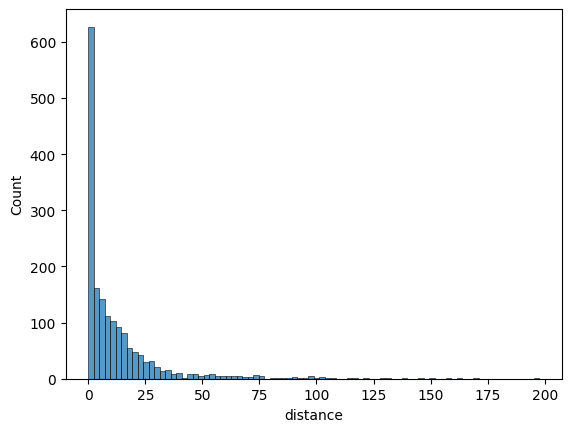

In [42]:
# Plot a histogram comprising all distances but cut at 250 so that outliers
# are not considered in scaling the axes
sns.histplot(tc_df.loc[tc_df['distance'] < 250, 'distance']);

In [49]:
# Only keep trees whose tree coordinates were not shifted more than 10 meters
tc_df = tc_df[tc_df['distance'] < 10]

# Reset the index as rows have been dropped
tc_df.reset_index(drop=True, inplace=True)

# Save the resulting data frame
tc_df.to_csv('./data/Laubbäume_utm32_shifted.csv', index=False)

We loose 35% of all trees be shifting their coordinates to the coordinates of a nearby treetop as we exclude all trees whose coordinates needed to be shifted farther than 10 meters. This is far from optimal and shows that the recorded tree coordinates do not automatically coincide with a treetop in the direct neighborhood. This might especially be the case for trees that are hidden under the tree crown of a larger tree or are less than three meters high as we did not allow tree tops lower than that to be detected.